# Part II Spatial Interaction Model
## Set up

In [523]:
#import the necessary libraries 
import pandas as pd
import statsmodels.api as sm
import scipy.stats
import numpy as np
from math import sqrt
import statsmodels.formula.api as smf

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import folium

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd



In [337]:
#set up the metric calculations
def CalcRSqaured(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

### Read in data

In [338]:
data = pd.read_csv('./london_flows.csv')
data.head()

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167


In [339]:
# Rename the columns
data.rename(columns = {'population':'orig_pop', 'jobs':'dest_jobs'}, inplace = True)
# Removing Battersea Park
data = data[(data['station_origin'] != 'Battersea Park')
           & (data['station_destination'] != 'Battersea Park')]
data.nunique()

station_origin           398
station_destination      398
flows                    822
orig_pop                 383
dest_jobs                377
distance               44895
dtype: int64

In [340]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61431 entries, 0 to 61473
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   station_origin       61431 non-null  object 
 1   station_destination  61431 non-null  object 
 2   flows                61431 non-null  int64  
 3   orig_pop             61431 non-null  int64  
 4   dest_jobs            61431 non-null  int64  
 5   distance             61431 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 3.3+ MB


### Remove Intra station flows

In [341]:
data[data['station_origin'] == data['station_destination']]

,station_origin,station_destination,flows,orig_pop,dest_jobs,distance
4985,Blackfriars,Blackfriars,1,6781,10849,0.0
8847,Canary Wharf,Canary Wharf,0,14632,58772,0.0
9444,Cannon Street,Cannon Street,0,3874,4698,0.0
16611,Elephant & Castle,Elephant & Castle,0,9325,6427,0.0
17552,Euston,Euston,0,17796,16800,0.0
17807,Euston Square,Euston Square,0,4926,8093,0.0
18940,Finsbury Park,Finsbury Park,0,24735,6769,0.0
21752,Hackney Central,Hackney Central,0,3370,2440,0.0
21809,Hackney Downs,Hackney Downs,1,843,835,0.0
22242,Hammersmith,Hammersmith,0,11818,18250,0.0


In [342]:
data['TotalNoIntra'] = data.apply(lambda x: 0 if x['station_origin'] == x['station_destination'] else x['flows'], axis=1)
data['offset'] = data.apply(lambda x: 0.0000000001 if x['station_origin'] == x['station_destination'] else 0, axis=1)
data = data[data['station_origin'] != data['station_destination']]
data.head()

,station_origin,station_destination,flows,orig_pop,dest_jobs,distance,TotalNoIntra,offset
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0,0.0
1,Abbey Road,Beckton,1,599,442,8510.121774,1,0.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,3,0.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,1,0.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,37,0.0


### Calculate the log values

In [343]:
# Calculate the log values
x_variables = ["orig_pop", "dest_jobs", "distance"]
log_x_vars = []
for x in x_variables:
    data[f"log_{x}"] = np.log(data[x])
    log_x_vars.append(f"log_{x}")

data.head()

,station_origin,station_destination,flows,orig_pop,dest_jobs,distance,TotalNoIntra,offset,log_orig_pop,log_dest_jobs,log_distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0,0.0,6.395262,11.271478,9.003504
1,Abbey Road,Beckton,1,599,442,8510.121774,1,0.0,6.395262,6.091310,9.049012
2,Abbey Road,Blackwall,3,599,665,3775.448872,3,0.0,6.395262,6.499787,8.236275
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,1,0.0,6.395262,10.981421,8.534348
4,Abbey Road,Canning Town,37,599,15428,2228.923167,37,0.0,6.395262,9.643939,7.709274


### Calculate Oi Dj

In [344]:
O_i = pd.DataFrame(data.groupby(["station_origin"])["flows"].agg(np.sum))
O_i.rename(columns = {'flows':'O_i'},inplace = True)
data = data.merge(O_i, on = 'station_origin', how = 'left')

D_j = pd.DataFrame(data.groupby(["station_destination"])["flows"].agg(np.sum))
D_j.rename(columns = {'flows':'D_j'},inplace = True)
data = data.merge(D_j, on = 'station_destination', how = 'left')

### Finalized data and flow matrix

In [345]:
data.head()

,station_origin,station_destination,flows,orig_pop,dest_jobs,distance,TotalNoIntra,offset,log_orig_pop,log_dest_jobs,log_distance,O_i,D_j
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0,0.0,6.395262,11.271478,9.003504,599,78549
1,Abbey Road,Beckton,1,599,442,8510.121774,1,0.0,6.395262,6.091310,9.049012,599,442
2,Abbey Road,Blackwall,3,599,665,3775.448872,3,0.0,6.395262,6.499787,8.236275,599,665
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,1,0.0,6.395262,10.981421,8.534348,599,58772
4,Abbey Road,Canning Town,37,599,15428,2228.923167,37,0.0,6.395262,9.643939,7.709274,599,15428


In [462]:
datamat = data.pivot_table(values = 'TotalNoIntra', index = 'station_origin', columns = 'station_destination', aggfunc = np.sum, margins = True, fill_value = 0)
datamat

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,32,599
Acton Central,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1224
Acton Town,0,0,0,3,17,0,35,0,0,11,...,77,3,6,9,0,0,0,0,0,3745
Aldgate,0,0,0,0,0,0,0,0,0,17,...,0,0,4,8,0,0,0,0,0,2886
Aldgate East,0,0,2,0,0,0,0,0,0,20,...,24,0,0,12,0,1,0,1,0,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,0,0,2,5,47,0,0,0,0,22,...,2,0,1,0,0,0,0,0,0,4868
Woodgrange Park,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,530
Woodside Park,0,0,1,26,11,0,0,0,0,59,...,0,0,0,0,0,0,0,0,0,3093


## Estimating Model Parameters

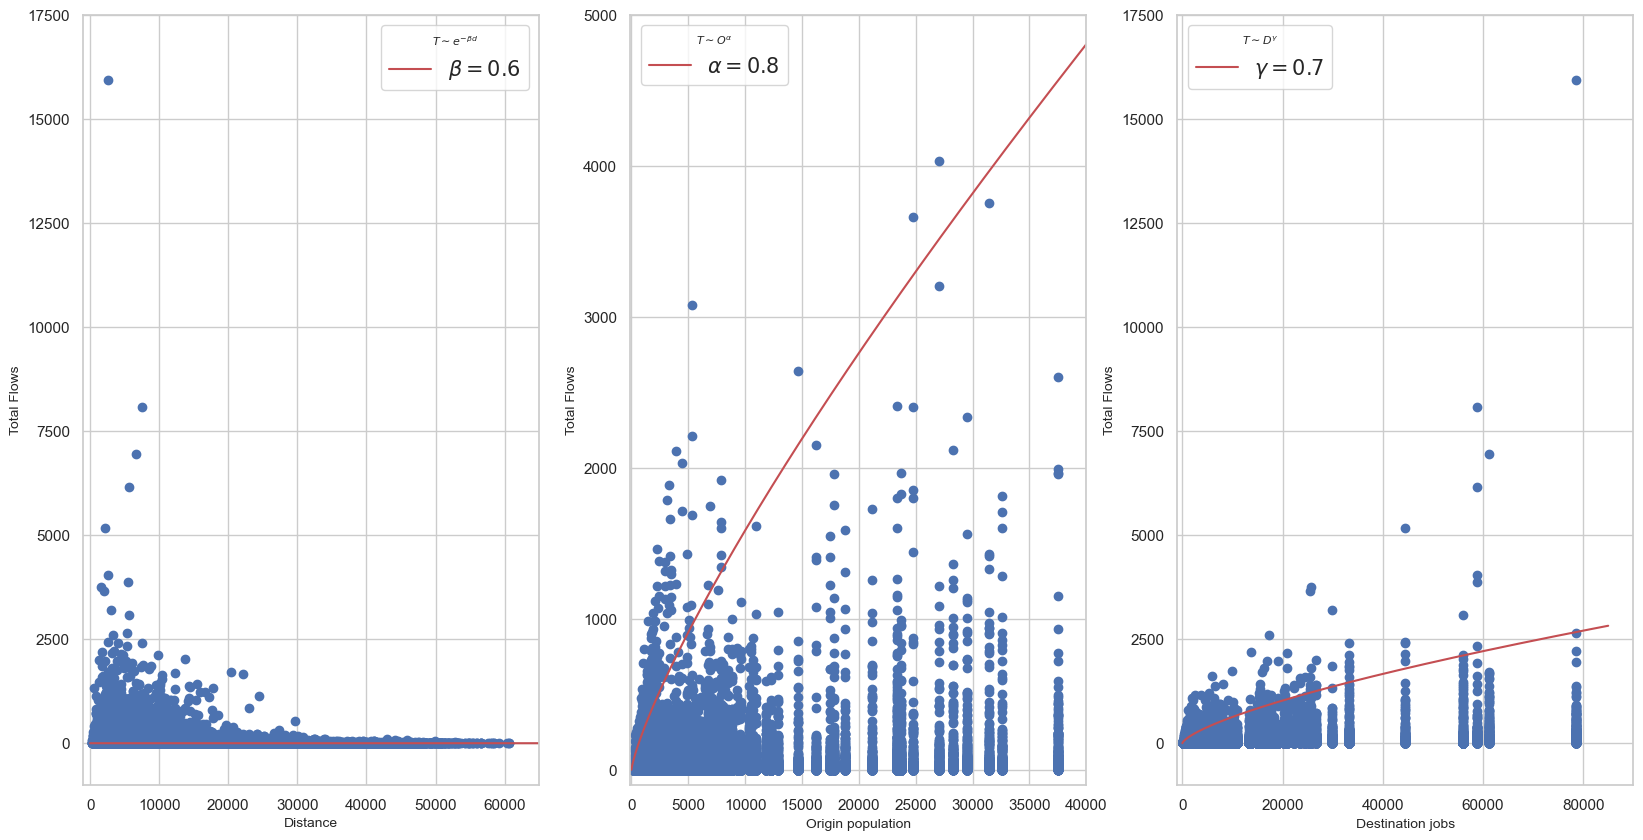

In [1100]:
#set the base axis
fig= plt.figure(figsize=(20,10))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
#scatter plot
ax1.scatter(x = data["distance"], y=data["flows"])
#line plot
line = np.arange(0.0002, 65000, 0.1)
ax1.plot(line, np.exp(-0.6*line), color ="r", label = "$\\beta=0.6$")
#add a legend
ax1.legend(title = "$T \\sim e^{-\\beta d}$", fontsize = 15, title_fontsize=8)
#axis limits
ax1.set_xlim([-1000,65000])
ax1.set_ylim([-1000, 17500])
#set the labels
ax1.set_xlabel("Distance", fontsize = 10)
ax1.set_ylabel("Total Flows", fontsize = 10)

#scatter plot
ax2.scatter(x = data["orig_pop"], y=data["flows"])
#line plot
line = np.arange(0.0002, 170_000, 0.1)
ax2.plot(line, line**0.8, color ="r", label = "$\\alpha=0.8$")
#add a legend
ax2.legend( fontsize = 15, title = "$T \sim O^{\\alpha}$", title_fontsize=8)
#axis limits
ax2.set_xlim([-100,40000])
ax2.set_ylim([-100, 5000])
#axis labels
ax2.set_xlabel("Origin population", fontsize = 10)
ax2.set_ylabel("Total Flows", fontsize = 10)

#scatter plot
ax3.scatter(x = data["dest_jobs"], y=data["flows"])
#line plot
line = np.arange(0, 85000, 0.1)
ax3.plot(line, line**0.7, color ="r", label = "$\\gamma=0.7$")
#add a legend
ax3.legend( fontsize = 15, title = "$T \sim D^{\\gamma}$", title_fontsize=8)
#axis limits
ax3.set_xlim([-1000,90000])
ax3.set_ylim([-1000, 17500])
#axis labels
ax3.set_xlabel("Destination jobs", fontsize = 10)
ax3.set_ylabel("Total Flows", fontsize = 10)

plt.savefig('./figures/est_params.png')
plt.show()

In [ ]:
Oi1_alpha = cdatasub["Oi1_origpop"]**alpha
Dj2_gamma = cdatasub["Dj2_destsal"]**gamma
dist_beta = cdatasub["Dist"]**-beta
T1 = Oi1_alpha*Dj2_gamma*dist_beta
k = T2/sum(T1)data["init_est"] = round(k*Oi1_alpha*Dj2_gamma*dist_beta, 0)

## Calibrating Parameters

### Unconstrained Model

In [348]:
#create the formula
formulas = ['flows ~ log_orig_pop + log_dest_jobs + log_distance',
            'flows ~ station_origin + log_dest_jobs + log_distance-1',
            'flows ~ log_orig_pop + station_destination + log_distance-1',
            'flows ~ station_origin + station_destination + log_distance-1']

formula_uncon = formulas[0]

#run a unconstrained sim
unconsim = smf.glm(formula = formulas[0], data=data, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(unconsim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61409
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2785e+06
Date:                Sat, 29 Apr 2023   Deviance:                   2.3848e+06
Time:                        12:26:56   Pearson chi2:                 4.76e+06
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -3.7475      0.014   -273.078

In [349]:
# K_0 = uncosim.params[0]
# alpha_0 = uncosim.params[1]
# gamma_0 = uncosim.params[2]
# beta_0 = -uncosim.params[3]
# data['unconEst'] = np.exp(K_0 + alpha_0 * data['log_orig_pop']
#                          + gamma_0 * data['log_dest_jobs']
#                          - beta_0 * data['log_distance'])


In [350]:
data["unconEst"] = np.round(unconsim.mu,0)
unconR2 = CalcRSqaured(data['flows'], data['unconEst'])
unconRMSE = CalcRMSE(data['flows'], data['unconEst'])

### Production Constrained Model

In [1103]:
#create the formula (the "-1" indicates no intercept in the regression model).
prod_form = formulas[1]
#run a production constrained sim
# prodSim = smf.glm(formula = prod_form, data=data, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(prodSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61013
Model Family:                 Poisson   Df Model:                          399
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0169e+06
Date:                Tue, 02 May 2023   Deviance:                   1.8615e+06
Time:                        07:25:32   Pearson chi2:                 2.78e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [352]:
data["prodEst"] = np.round(prodSim.mu,0)
prodR2 = CalcRSqaured(data['flows'], data['prodEst'])
prodRMSE = CalcRMSE(data['flows'], data['prodEst'])

### Attraction Constrained Model

In [353]:
#create the formula (the "-1" indicates no intercept in the regression model).
attr_form = formulas[2]
#run a production constrained sim
attrsim = smf.glm(formula = attr_form, data=data, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
# print(attrsim.summary())

In [354]:
data["attrEst"] = np.round(attrsim.mu,0)
attrR2 = CalcRSqaured(data['flows'], data['attrEst'])
attrRMSE = CalcRMSE(data['flows'], data['attrEst'])

### Doubly Constrained Model

In [355]:
#create the formula (the "-1" indicates no intercept in the regression model).
dbl_form = formulas[3]
#run a doubly constrained sim
doubSim = smf.glm(formula = dbl_form, data=data, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
# print(doubSim.summary())

In [356]:
data["dblEst"] = np.round(doubSim.mu,0)
dblR2 = CalcRSqaured(data['flows'], data['dblEst'])
dblRMSE = CalcRMSE(data['flows'], data['dblEst'])

### Negative Exponential Function

In [357]:
formulas_2 = ['flows ~ log_orig_pop + log_dest_jobs + distance',
            'flows ~ station_origin + log_dest_jobs + distance-1',
            'flows ~ log_orig_pop + station_destination + distance-1',
            'flows ~ station_origin + station_destination + distance-1']

# run regression with negative exponential function 
unconsim2 = smf.glm(formula = formulas_2[0], data=data, family=sm.families.Poisson()).fit()
prodSim2 = smf.glm(formula = formulas_2[1], data=data, family=sm.families.Poisson()).fit()
attrsim2 = smf.glm(formula = formulas_2[2], data=data, family=sm.families.Poisson()).fit()
doubSim2 = smf.glm(formula = formulas_2[3], data=data, family=sm.families.Poisson()).fit()

In [358]:
data["unconEst2"] = np.round(unconsim2.mu,0)
data["prodEst2"] = np.round(prodSim2.mu,0)
data["attrEst2"] = np.round(attrsim2.mu,0)
data["dblEst2"] = np.round(doubSim2.mu,0)

In [359]:
data.head()

,station_origin,station_destination,flows,orig_pop,dest_jobs,distance,TotalNoIntra,offset,log_orig_pop,log_dest_jobs,...,O_i,D_j,unconEst,prodEst,attrEst,dblEst,unconEst2,prodEst2,attrEst2,dblEst2
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0,0.0,6.395262,11.271478,...,599,78549,50.0,55.0,53.0,55.0,62.0,78.0,71.0,77.0
1,Abbey Road,Beckton,1,599,442,8510.121774,1,0.0,6.395262,6.091310,...,599,442,1.0,1.0,3.0,2.0,1.0,1.0,3.0,3.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,3,0.0,6.395262,6.499787,...,599,665,2.0,3.0,4.0,3.0,3.0,4.0,5.0,4.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,1,0.0,6.395262,10.981421,...,599,58772,53.0,66.0,70.0,77.0,66.0,99.0,93.0,112.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,37,0.0,6.395262,9.643939,...,599,15428,32.0,49.0,33.0,45.0,32.0,56.0,36.0,48.0


In [360]:
unconR2_exp = CalcRSqaured(data['flows'], data['unconEst2'])
unconRMSE_exp = CalcRMSE(data['flows'], data['unconEst2'])
prodR2_exp = CalcRSqaured(data['flows'], data['prodEst2'])
prodRMSE_exp = CalcRMSE(data['flows'], data['prodEst2'])
attrR2_exp = CalcRSqaured(data['flows'], data['attrEst2'])
attrRMSE_exp = CalcRMSE(data['flows'], data['attrEst2'])
dblR2_exp = CalcRSqaured(data['flows'], data['dblEst2'])
dblRMSE_exp = CalcRMSE(data['flows'], data['dblEst2'])

In [1104]:
prodSim2.params[-2:]

log_dest_jobs    0.755222
distance        -0.000153
dtype: float64

### Comparison

In [361]:
model_com = {}
model_com['Negative Power'] = pd.DataFrame(np.array([[unconR2, unconRMSE], 
                                                     [prodR2,prodRMSE],
                                                     [attrR2,attrRMSE],
                                                     [dblR2, dblRMSE]]),
                                           columns=['R^2', 'RMSE'], index = ['Unconstrained Model', ' Production Constrained Model','Attraction Constrained Model', 'Doubly Constrained Model'])
pd.concat(model_com, axis = 1)
model_com['Negative Exponential'] = pd.DataFrame(np.array([[unconR2_exp, unconRMSE_exp], 
                                                     [prodR2_exp,prodRMSE_exp],
                                                     [attrR2_exp,attrRMSE_exp],
                                                     [dblR2_exp, dblRMSE_exp]]),
                                           columns=['R^2', 'RMSE'], index = ['Unconstrained Model', ' Production Constrained Model','Attraction Constrained Model', 'Doubly Constrained Model'])
pd.concat(model_com, axis = 1)

Negative Power          Negative Exponential  \
                                         R^2     RMSE                  R^2   
Unconstrained Model                 0.321190  108.334             0.362248   
 Production Constrained Model       0.388276  102.893             0.468065   
Attraction Constrained Model        0.349932  106.013             0.399954   
Doubly Constrained Model            0.407685  101.335             0.497843   

                                        
                                  RMSE  
Unconstrained Model            105.723  
 Production Constrained Model   96.263  
Attraction Constrained Model   102.168  
Doubly Constrained Model        93.401

### productive constrained + negative exponential

In [463]:
datamat1 = data.pivot_table(values = 'prodEst2', index = 'station_origin', columns = 'station_destination', 
                            aggfunc=np.sum, margins = True, fill_value = 0)
datamat1

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,7,595.0
Acton Central,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1226.0
Acton Town,0,0,0,13,13,0,14,0,0,16,...,13,3,2,20,0,0,0,1,0,3744.0
Aldgate,0,0,1,0,37,0,0,0,0,27,...,2,0,2,2,0,1,0,1,0,2885.0
Aldgate East,0,0,1,40,0,0,0,0,0,29,...,2,0,3,2,0,1,0,1,0,3160.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,0,0,1,41,52,0,0,0,0,30,...,2,0,6,0,0,0,0,0,0,4867.0
Woodgrange Park,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,532.0
Woodside Park,0,0,2,19,19,0,0,0,0,32,...,3,0,4,0,0,0,0,0,0,3100.0


In [383]:
#pulling out the parameter values
coefs = pd.DataFrame(prodSim2.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha_i", "index":"coef"}, inplace = True)
coefs

,coef,alpha_i
0,station_origin[Abbey Road],-2.914322
1,station_origin[Acton Central],-1.162092
2,station_origin[Acton Town],-1.613081
3,station_origin[Aldgate],-2.943047
4,station_origin[Aldgate East],-2.854752
...,...,...
395,station_origin[Woodgrange Park],-0.896422
396,station_origin[Woodside Park],-1.149110
397,station_origin[Woolwich Arsenal],0.518041
398,log_dest_jobs,0.755222


In [388]:
# This step get rid of the OrigCodeNew[] in the coef index for merging
to_repl = ["station_origin", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "")
#then once you have done this you can join them back into the dataframes
data = data.merge(coefs, left_on="station_origin", right_on="coef", how = "left")
data.drop(columns = ["coef"], inplace = True)
#check this has worked
data.head()

/var/folders/nq/s_s2wz510h30x4pb288s5y0h0000gn/T/ipykernel_23361/1441795448.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  coefs["coef"] = coefs["coef"].str.replace(x, "")


,station_origin,station_destination,flows,orig_pop,dest_jobs,distance,TotalNoIntra,offset,log_orig_pop,log_dest_jobs,...,attrEst,dblEst,unconEst2,prodEst2,attrEst2,dblEst2,prodEst2_param,dest_jobs_scenA,prod_scenA_est,alpha_i
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0,0.0,6.395262,11.271478,...,53.0,55.0,62.0,78.0,71.0,77.0,78.0,78549.0,78,-2.914322
1,Abbey Road,Beckton,1,599,442,8510.121774,1,0.0,6.395262,6.091310,...,3.0,2.0,1.0,1.0,3.0,3.0,1.0,442.0,1,-2.914322
2,Abbey Road,Blackwall,3,599,665,3775.448872,3,0.0,6.395262,6.499787,...,4.0,3.0,3.0,4.0,5.0,4.0,4.0,665.0,4,-2.914322
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,1,0.0,6.395262,10.981421,...,70.0,77.0,66.0,99.0,93.0,112.0,99.0,29386.0,59,-2.914322
4,Abbey Road,Canning Town,37,599,15428,2228.923167,37,0.0,6.395262,9.643939,...,33.0,45.0,32.0,56.0,36.0,48.0,56.0,15428.0,56,-2.914322


In [389]:
gamma = prodSim2.params[-2]
beta = -prodSim2.params[-1]
data.head()

,station_origin,station_destination,flows,orig_pop,dest_jobs,distance,TotalNoIntra,offset,log_orig_pop,log_dest_jobs,...,attrEst,dblEst,unconEst2,prodEst2,attrEst2,dblEst2,prodEst2_param,dest_jobs_scenA,prod_scenA_est,alpha_i
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0,0.0,6.395262,11.271478,...,53.0,55.0,62.0,78.0,71.0,77.0,78.0,78549.0,78,-2.914322
1,Abbey Road,Beckton,1,599,442,8510.121774,1,0.0,6.395262,6.091310,...,3.0,2.0,1.0,1.0,3.0,3.0,1.0,442.0,1,-2.914322
2,Abbey Road,Blackwall,3,599,665,3775.448872,3,0.0,6.395262,6.499787,...,4.0,3.0,3.0,4.0,5.0,4.0,4.0,665.0,4,-2.914322
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,1,0.0,6.395262,10.981421,...,70.0,77.0,66.0,99.0,93.0,112.0,99.0,29386.0,59,-2.914322
4,Abbey Road,Canning Town,37,599,15428,2228.923167,37,0.0,6.395262,9.643939,...,33.0,45.0,32.0,56.0,36.0,48.0,56.0,15428.0,56,-2.914322


In [390]:
data['prodEst2_param'] = np.exp(data['alpha_i']+ gamma*np.log(data['dest_jobs']) - beta*data['distance'])
data['prodEst2_param'] = round(data['prodEst2_param'],0)
datamat12 = data.pivot_table(values = 'prodEst2_param', index = 'station_origin', columns = 'station_destination', 
                            aggfunc=np.sum, margins = True, fill_value = 0)
datamat12

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,7,595.0
Acton Central,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1226.0
Acton Town,0,0,0,13,13,0,14,0,0,16,...,13,3,2,20,0,0,0,1,0,3744.0
Aldgate,0,0,1,0,37,0,0,0,0,27,...,2,0,2,2,0,1,0,1,0,2885.0
Aldgate East,0,0,1,40,0,0,0,0,0,29,...,2,0,3,2,0,1,0,1,0,3160.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,0,0,1,41,52,0,0,0,0,30,...,2,0,6,0,0,0,0,0,0,4867.0
Woodgrange Park,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,532.0
Woodside Park,0,0,2,19,19,0,0,0,0,32,...,3,0,4,0,0,0,0,0,0,3100.0


In [309]:
datamat

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,32,599
Acton Central,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1224
Acton Town,0,0,0,3,17,0,35,0,0,11,...,77,3,6,9,0,0,0,0,0,3745
Aldgate,0,0,0,0,0,0,0,0,0,17,...,0,0,4,8,0,0,0,0,0,2886
Aldgate East,0,0,2,0,0,0,0,0,0,20,...,24,0,0,12,0,1,0,1,0,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,0,0,2,5,47,0,0,0,0,22,...,2,0,1,0,0,0,0,0,0,4868
Woodgrange Park,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,530
Woodside Park,0,0,1,26,11,0,0,0,0,59,...,0,0,0,0,0,0,0,0,0,3093


In [321]:
max(abs(datamat1['All']-datamat['All'])/datamat['All'])

0.045845272206303724

## Scenario A
### Estimate with prod exp parameters

In [391]:
def new_jobs(row):
    if row["station_destination"] == "Canary Wharf": #replace
        val = row["dest_jobs"]*0.5
    else:
        val = row["dest_jobs"]
    return val
        
data["dest_jobs_scenA"] = data.apply(new_jobs, axis =1)
data[data['station_destination'] == "Canary Wharf"]

,station_origin,station_destination,flows,orig_pop,dest_jobs,distance,TotalNoIntra,offset,log_orig_pop,log_dest_jobs,...,attrEst,dblEst,unconEst2,prodEst2,attrEst2,dblEst2,prodEst2_param,dest_jobs_scenA,prod_scenA_est,alpha_i
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,1,0.0,6.395262,10.981421,...,70.0,77.0,66.0,99.0,93.0,112.0,99.0,29386.0,59,-2.914322
126,Acton Town,Canary Wharf,57,3745,58772,20398.165882,57,0.0,8.228177,10.981421,...,113.0,89.0,60.0,35.0,75.0,44.0,35.0,29386.0,21,-1.613081
348,Aldgate,Canary Wharf,1,2886,58772,6564.419680,1,0.0,7.967627,10.981421,...,191.0,73.0,174.0,77.0,247.0,107.0,77.0,29386.0,46,-2.943047
595,Aldgate East,Canary Wharf,3,3172,58772,5127.998899,3,0.0,8.062118,10.981421,...,240.0,105.0,212.0,105.0,305.0,146.0,105.0,29386.0,62,-2.854752
817,All Saints,Canary Wharf,67,740,58772,1340.088733,67,0.0,6.606650,10.981421,...,190.0,239.0,107.0,183.0,157.0,186.0,183.0,29386.0,108,-2.878322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60534,Wood Green,Canary Wharf,64,6667,58772,16849.246595,64,0.0,8.804925,10.981421,...,196.0,196.0,124.0,105.0,161.0,145.0,105.0,29386.0,62,-1.060757
60777,Wood Lane,Canary Wharf,0,1088,58772,17092.091760,0,0.0,6.992096,10.981421,...,50.0,26.0,34.0,12.0,43.0,16.0,12.0,29386.0,7,-3.205331
61001,Woodford,Canary Wharf,192,4868,58772,13963.787075,192,0.0,8.490438,10.981421,...,175.0,240.0,129.0,250.0,172.0,347.0,250.0,29386.0,148,-0.633605
61233,Woodside Park,Canary Wharf,42,3093,58772,22356.567178,42,0.0,8.036897,10.981421,...,92.0,98.0,44.0,41.0,54.0,54.0,41.0,29386.0,24,-1.149110


In [464]:
data["prod_scenA_est"] = np.exp(data["alpha_i"]+gamma*np.log(data["dest_jobs_scenA"]) - beta*data["distance"])
data['prod_scenA_est'] = round(data['prod_scenA_est'], 0).astype(int)
datamat2 = data.pivot_table(values ="prod_scenA_est", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True, fill_value = 0)
datamat2.to_csv('./data/datamat2.csv')
datamat2

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,7,555
Acton Central,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1226
Acton Town,0,0,0,13,13,0,14,0,0,16,...,13,3,2,20,0,0,0,1,0,3730
Aldgate,0,0,1,0,37,0,0,0,0,27,...,2,0,2,2,0,1,0,1,0,2854
Aldgate East,0,0,1,40,0,0,0,0,0,29,...,2,0,3,2,0,1,0,1,0,3117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,0,0,1,41,52,0,0,0,0,30,...,2,0,6,0,0,0,0,0,0,4765
Woodgrange Park,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,532
Woodside Park,0,0,2,19,19,0,0,0,0,32,...,3,0,4,0,0,0,0,0,0,3083


In [394]:
datamat1

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,7,595.0
Acton Central,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1226.0
Acton Town,0,0,0,13,13,0,14,0,0,16,...,13,3,2,20,0,0,0,1,0,3744.0
Aldgate,0,0,1,0,37,0,0,0,0,27,...,2,0,2,2,0,1,0,1,0,2885.0
Aldgate East,0,0,1,40,0,0,0,0,0,29,...,2,0,3,2,0,1,0,1,0,3160.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,0,0,1,41,52,0,0,0,0,30,...,2,0,6,0,0,0,0,0,0,4867.0
Woodgrange Park,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,532.0
Woodside Park,0,0,2,19,19,0,0,0,0,32,...,3,0,4,0,0,0,0,0,0,3100.0


### Calculate New Ai

Flow terminating at Canary Wharf has increased by 19438. To conserve the number of commuters, we need to calculate new $A_i$ value.

In [ ]:
#calculate some new wj^alpha and d_ij^beta values, using the original salary
Wj_gamma = cdatasub["Dj2_destsal"]**gamma
dist_beta = cdatasub["Dist"]**-beta
#calcualte the first stage of the Ai values
cdatasub["Ai1"] = Dj2_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(cdatasub.groupby(["OrigCodeNew"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i"}, inplace=True)
#and write the A_i values back into the dataframe
cdatasub = cdatasub.merge(A_i, left_on="OrigCodeNew", right_index=True, how="left")
cdatasub.head()

In [396]:
Wj_gamma = data['dest_jobs_scenA']**gamma
dist_beta = np.exp(-beta*data['distance'])
#calcualte the first stage of the Ai values
data['Ai1'] = Wj_gamma * dist_beta
A_i = pd.DataFrame(data.groupby(['station_origin'])['Ai1'].agg(np.sum))
# divide by 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i"}, inplace=True)
# merge into dataframe
data = data.merge(A_i, left_on = 'station_origin', right_index = True, how = 'left').drop(['Ai1'],axis = 1)
data.head()

,station_origin,station_destination,flows,orig_pop,dest_jobs,distance,TotalNoIntra,offset,log_orig_pop,log_dest_jobs,...,unconEst2,prodEst2,attrEst2,dblEst2,prodEst2_param,dest_jobs_scenA,prod_scenA_est,alpha_i,Ai1,A_i
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0,0.0,6.395262,11.271478,...,62.0,78.0,71.0,77.0,78.0,78549.0,78,-2.914322,1432.231104,0.000097
1,Abbey Road,Beckton,1,599,442,8510.121774,1,0.0,6.395262,6.091310,...,1.0,1.0,3.0,3.0,1.0,442.0,1,-2.914322,27.026714,0.000097
2,Abbey Road,Blackwall,3,599,665,3775.448872,3,0.0,6.395262,6.499787,...,3.0,4.0,5.0,4.0,4.0,665.0,4,-2.914322,75.982904,0.000097
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,1,0.0,6.395262,10.981421,...,66.0,99.0,93.0,112.0,99.0,29386.0,59,-2.914322,1086.638601,0.000097
4,Abbey Road,Canning Town,37,599,15428,2228.923167,37,0.0,6.395262,9.643939,...,32.0,56.0,36.0,48.0,56.0,15428.0,56,-2.914322,1034.750388,0.000097


Now we have the new $A_i$, let's generate some new flows under scenario A.

In [465]:
data['prod_scenA_est2'] = data['A_i']*data['O_i']*Wj_gamma*dist_beta
data['prod_scenA_est2'] = round(data['prod_scenA_est2'],0)
datamat3 = data.pivot_table(values ="prod_scenA_est2", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True, fill_value = 0)
datamat3.to_csv('./data/datamat3.csv')
datamat3

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8,597.0
Acton Central,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1226.0
Acton Town,0,0,0,13,13,0,14,0,0,16,...,13,3,2,20,0,0,0,1,0,3750.0
Aldgate,0,0,1,0,38,0,0,0,0,28,...,2,0,3,2,0,1,0,1,0,2886.0
Aldgate East,0,0,1,41,0,0,0,0,0,29,...,2,0,3,2,0,1,0,1,0,3167.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,0,0,1,42,53,0,0,0,0,31,...,2,0,6,0,0,0,0,0,0,4860.0
Woodgrange Park,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,532.0
Woodside Park,0,0,2,19,19,0,0,0,0,32,...,3,0,4,0,0,0,0,0,0,3102.0


In [402]:
datamat['Canary Wharf']['All']

58772

In [405]:
CW = pd.DataFrame({'Real':datamat['Canary Wharf']['All'], 
                   'prodEst': datamat1['Canary Wharf']['All'],
                  'Scenario A': datamat2['Canary Wharf']['All'],
                  'Scenario A Adjusted': datamat3['Canary Wharf']['All']}, index = ['flows'])
CW

,Real,prodEst,Scenario A,Scenario A Adjusted
flows,58772,47681,28243,29489


## Scenario B
A significant increase in the cost of transport. The effect of distance increase. $\beta$ increase. Choose two values for $\beta$.

In [409]:
beta1 = 0.0003
beta2 = 0.0005

In [408]:
data.head()

,station_origin,station_destination,flows,orig_pop,dest_jobs,distance,TotalNoIntra,offset,log_orig_pop,log_dest_jobs,...,prodEst2,attrEst2,dblEst2,prodEst2_param,dest_jobs_scenA,prod_scenA_est,alpha_i,Ai1,A_i,prod_scenA_est2
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0,0.0,6.395262,11.271478,...,78.0,71.0,77.0,78.0,78549.0,78,-2.914322,1432.231104,0.000097,83.0
1,Abbey Road,Beckton,1,599,442,8510.121774,1,0.0,6.395262,6.091310,...,1.0,3.0,3.0,1.0,442.0,1,-2.914322,27.026714,0.000097,2.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,3,0.0,6.395262,6.499787,...,4.0,5.0,4.0,4.0,665.0,4,-2.914322,75.982904,0.000097,4.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,1,0.0,6.395262,10.981421,...,99.0,93.0,112.0,99.0,29386.0,59,-2.914322,1086.638601,0.000097,63.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,37,0.0,6.395262,9.643939,...,56.0,36.0,48.0,56.0,15428.0,56,-2.914322,1034.750388,0.000097,60.0


In [414]:
# beta1 = 0.0003
data['prod_scenB_est1'] = np.exp(data['alpha_i'] + gamma* np.log(data['dest_jobs']) - beta1 * data['distance'])
data['prod_scenB_est1'] = round(data['prod_scenB_est1'],0)
# beta2 = 0.0005
data['prod_scenB_est2'] = np.exp(data['alpha_i'] + gamma* np.log(data['dest_jobs']) - beta2 * data['distance'])
data['prod_scenB_est2'] = round(data['prod_scenB_est2'],0)

In [466]:
datamat4  = data.pivot_table(values ="prod_scenB_est1", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True, fill_value = 0)
datamat4


station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,369.0
Acton Central,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,453.0
Acton Town,0,0,0,1,1,0,7,0,0,2,...,1,0,0,8,0,0,0,0,0,955.0
Aldgate,0,0,0,0,30,0,0,0,0,16,...,0,0,0,0,0,0,0,0,0,1580.0
Aldgate East,0,0,0,32,0,0,0,0,0,17,...,0,0,0,0,0,0,0,0,0,1704.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,0,0,0,4,6,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,728.0
Woodgrange Park,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,236.0
Woodside Park,0,0,0,2,1,0,0,0,0,4,...,0,0,0,0,0,0,0,0,0,415.0


In [467]:
datamat5 = data.pivot_table(values ="prod_scenB_est2", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True, fill_value = 0)
datamat5

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,227.0
Acton Central,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,198.0
Acton Town,0,0,0,0,0,0,2,0,0,0,...,0,0,0,2,0,0,0,0,0,288.0
Aldgate,0,0,0,0,23,0,0,0,0,8,...,0,0,0,0,0,0,0,0,0,870.0
Aldgate East,0,0,0,24,0,0,0,0,0,8,...,0,0,0,0,0,0,0,0,0,915.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,151.0
Woodgrange Park,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,118.0
Woodside Park,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,80.0


In [472]:
to_comp = (datamat,datamat1,datamat2,datamat3,datamat4,datamat5)
names = ['real','prod','scenA','scenA_adj','beta1','beta2']
for i, df in enumerate(to_comp):
    print(i)
    col_name = f'orig_total_{names[i]}'
    row_name = f'dest_total_{names[i]}'
    df.rename(columns = {'All':col_name}, index = {'All':row_name}, inplace = True)

0
1
2
3
4
5


In [493]:
flow_origin = pd.concat([
    # datamat.iloc[:-1,-1], 
                      datamat1.iloc[:-1,-1], 
                      # datamat2.iloc[:-1,-1], 
                      # datamat3.iloc[:-1,-1], 
                      datamat4.iloc[:-1,-1], 
                      datamat5.iloc[:-1,-1]], axis = 1)
flow_origin

,orig_total_prod,orig_total_beta1,orig_total_beta2
station_origin,,,
Abbey Road,595.0,369.0,227.0
Acton Central,1226.0,453.0,198.0
Acton Town,3744.0,955.0,288.0
Aldgate,2885.0,1580.0,870.0
Aldgate East,3160.0,1704.0,915.0
...,...,...,...
Wood Street,1365.0,401.0,167.0
Woodford,4867.0,728.0,151.0
Woodgrange Park,532.0,236.0,118.0


In [494]:
flow_dest = pd.concat([
    # datamat.iloc[-1,:-1], 
                      datamat1.iloc[-1,:-1], 
                      # datamat2.iloc[-1,:-1], 
                      # datamat3.iloc[-1,:-1], 
                      datamat4.iloc[-1,:-1], 
                      datamat5.iloc[-1,:-1]], axis = 1)
flow_dest

,dest_total_prod,dest_total_beta1,dest_total_beta2
station_destination,,,
Abbey Road,392.0,235.0,146.0
Acton Central,359.0,115.0,49.0
Acton Town,2161.0,661.0,272.0
Aldgate,8549.0,3373.0,1588.0
Aldgate East,9502.0,3704.0,1673.0
...,...,...,...
Wood Street,397.0,186.0,100.0
Woodford,660.0,214.0,81.0
Woodgrange Park,160.0,72.0,39.0


In [506]:
sns.set_style("whitegrid")

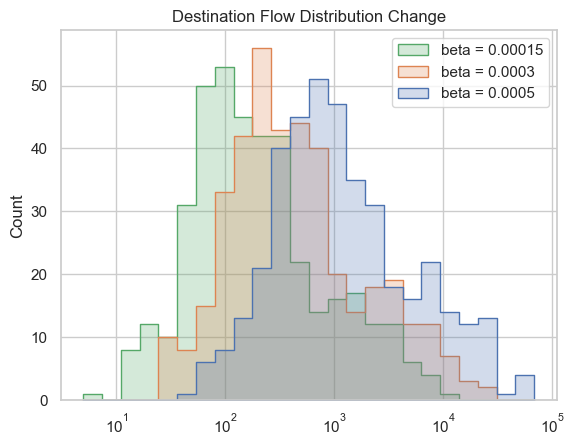

In [520]:
plt.figure()
sns.histplot(data = flow_dest, element="step",log_scale = True)
plt.legend(labels=[f"beta = {round(beta,5)}", f"beta = {beta1}", f"beta = {beta2}"])
plt.title("Destination Flow Distribution Change")
plt.savefig("./figures/dest_flow.png")

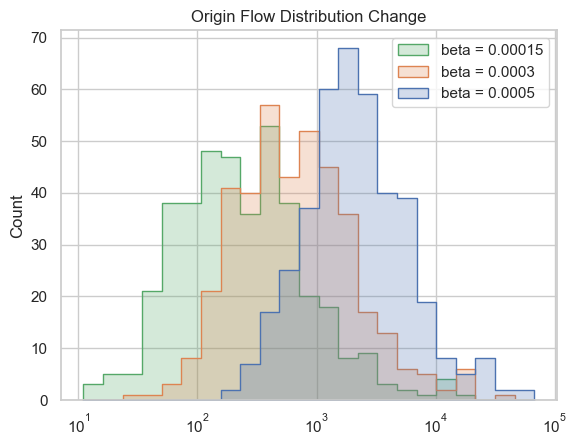

In [521]:
plt.figure
sns.histplot(data = flow_origin, element="step",log_scale = True)
plt.legend(labels=[f"beta = {round(beta,5)}", f"beta = {beta1}", f"beta = {beta2}"])
plt.title("Origin Flow Distribution Change")
plt.savefig("./figures/orig_flow.png")

# Part I London's Underground resilience


In [932]:
import networkx as nx
import matplotlib.pyplot as plt

In [933]:
station_edges = pd.read_csv("london_flows.csv")
station_edges["flows"] = station_edges["flows"].astype(str).astype(float)

# Create a directed graph from the edge list
g = nx.from_pandas_edgelist(station_edges, 'station_origin', 'station_destination', ['flows'], 
                            create_using=nx.DiGraph())


In [934]:
# pos = nx.spring_layout(g)
# fig, ax = plt.subplots(figsize=(15, 15))
# nx.draw_networkx(g,
#                  pos,
#                  with_labels = True,
#                  node_size=1,  
#                  font_size=5,
#                  edge_color="lightblue")
# fig.savefig('network')

In [935]:
print(nx.info(g))

DiGraph with 399 nodes and 61464 edges


/var/folders/nq/s_s2wz510h30x4pb288s5y0h0000gn/T/ipykernel_23361/1432719896.py:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(g))


In [936]:
reciprocity = nx.reciprocity(g) 
reciprocity

0.967916178576077

## Topological Network
### Centrality Measures
Select 3 measures. Give the definition. Link to the underground context. compute the measure. give the results in a table.

#### Degree Centrality

In [937]:
# #topological indegree centrality
# indegree_t = nx.in_degree_centrality(g)
# #add the in degree centrality as attribute to the nodes in the graph
# nx.set_node_attributes(g,dict(indegree_t),'indegree_t')
# # To dataframe using the nodes as the index
# df_indeg_t = pd.DataFrame.from_dict(indegree_t,columns=['indegree_t'],orient='index')
# df_indeg_t_sorted = df_indeg_t.sort_values(by = 'indegree_t', ascending=False).reset_index().rename(columns = {'index':'station_name'})
# df_indeg_t_sorted[0:10]

#### Closeness Centrality

In [938]:
#topological closeness
closeness_t=nx.closeness_centrality(g)

# Let us add the closeness centrality as attribute to the nodes in the graph
nx.set_node_attributes(g,closeness_t,'closeness_t')

# To dataframe using the nodes as the index
df_clos_t = pd.DataFrame.from_dict(closeness_t,columns=['closeness_t'],orient='index')
df_clos_t_sorted = df_clos_t.sort_values(by = 'closeness_t', ascending=False).reset_index().rename(columns = {'index':'station_name'})
df_clos_t_sorted[0:10]

,station_name,closeness_t
0,Stratford,0.927739
1,Highbury & Islington,0.820619
2,Whitechapel,0.812245
3,Canada Water,0.810591
4,Canary Wharf,0.808943
5,Canning Town,0.807302
6,Bank and Monument,0.807302
7,Liverpool Street,0.805668
8,West Brompton,0.799197
9,Richmond,0.796000


#### Betweenness Centrality

In [939]:
### Topological betweenness centrality:

#Compute the betweenness centrality for the network, without using weights:
betweenness_t=nx.betweenness_centrality(g, normalized=False)

# We can add these values to the nodes attributes:
nx.set_node_attributes(g,betweenness_t,'betweenness_t')

# To dataframe using the nodes as the index
df_bet_t = pd.DataFrame.from_dict(betweenness_t,columns=['betweenness_t'],orient='index')
df_bet_t_sorted = df_bet_t.sort_values(by = 'betweenness_t', ascending=False).reset_index().rename(columns = {'index':'station_name'})
df_bet_t_sorted[0:10]

,station_name,betweenness_t
0,Stratford,16097.992318
1,Liverpool Street,5549.649446
2,Canary Wharf,4482.232329
3,Canning Town,4462.526639
4,Bank and Monument,4420.957075
5,West Ham,3722.303475
6,Highbury & Islington,3637.438775
7,Whitechapel,3295.608297
8,Canada Water,3078.875366
9,Shadwell,2626.359364


#### PageRank

In [940]:
pagerank_t = nx.pagerank(g)

# We can add these values to the nodes attributes:
nx.set_node_attributes(g,pagerank_t,'pagerank_t')

# To dataframe using the nodes as the index
df_pr_t = pd.DataFrame.from_dict(pagerank_t,columns=['pagerank_t'],orient='index')
df_pr_t_sorted = df_pr_t.sort_values(by = 'pagerank_t', ascending=False).reset_index().rename(columns = {'index':'station_name'})
df_pr_t_sorted[0:10]

,station_name,pagerank_t
0,Stratford,0.007599
1,Liverpool Street,0.005496
2,Canary Wharf,0.005066
3,Canning Town,0.005064
4,Bank and Monument,0.005014
5,Highbury & Islington,0.005011
6,Whitechapel,0.004811
7,West Ham,0.004767
8,Canada Water,0.004719
9,Richmond,0.004675


In [941]:
# harmo_t = nx.harmonic_centrality(g)

# # We can add these values to the nodes attributes:
# nx.set_node_attributes(g,harmo_t,'harmo_t')

# # To dataframe using the nodes as the index
# df_harmo_t = pd.DataFrame.from_dict(harmo_t,columns=['harmo_t'],orient='index')
# df_harmo_t_sorted = df_harm_t.sort_values(by = 'harmo_t', ascending=False).reset_index().rename(columns = {'index':'station_name'})
# df_harmo_t_sorted[0:10]

#### Rank Result

In [942]:
list(g.nodes(data = True))[0]

('Abbey Road',
 {'closeness_t': 0.5142118863049095,
  'betweenness_t': 1.5709653477279315,
  'pagerank_t': 0.001461553296369048})

In [943]:
ranks = [df_clos_t_sorted, df_bet_t_sorted,df_pr_t_sorted]
measures_rank = pd.concat(ranks, axis = 1)
measures_rank[:10].to_csv('./data/top_measures_rank.csv')
measures_rank[:10].to_csv()

,station_name,closeness_t,station_name,betweenness_t,station_name,pagerank_t
0,Stratford,0.927739,Stratford,16097.992318,Stratford,0.007599
1,Highbury & Islington,0.820619,Liverpool Street,5549.649446,Liverpool Street,0.005496
2,Whitechapel,0.812245,Canary Wharf,4482.232329,Canary Wharf,0.005066
3,Canada Water,0.810591,Canning Town,4462.526639,Canning Town,0.005064
4,Canary Wharf,0.808943,Bank and Monument,4420.957075,Bank and Monument,0.005014
5,Canning Town,0.807302,West Ham,3722.303475,Highbury & Islington,0.005011
6,Bank and Monument,0.807302,Highbury & Islington,3637.438775,Whitechapel,0.004811
7,Liverpool Street,0.805668,Whitechapel,3295.608297,West Ham,0.004767
8,West Brompton,0.799197,Canada Water,3078.875366,Canada Water,0.004719
9,Richmond,0.796000,Shadwell,2626.359364,Richmond,0.004675


### Impact Measures
The impact of removing nodes on the network. find 2 measures. Need to be global measures. 

#### Average Clustering Coefficient

In [916]:
acc = nx.average_clustering(g)
acc

0.8367515282069367

#### Assortativity Coefficient

In [917]:
dac = nx.degree_assortativity_coefficient (g)
dac

0.26362972993307354

### Node Removal


For each of the centrality measures selected in 1.- remove at least 10 nodes following two different strategies. 

A) Non-sequential removal: using your table in 1.- remove 1 node at a time following the rank in the table, i.e. from the most important one to the 10th most important one. After each removal, evaluate the impact of the removal using your two measures in 2.-, and proceed until you have removed at least 10 nodes. 

B) Sequential: remove the highest ranked node and evaluate the impact using the 2 measures. After removal, re-compute the centrality measure. Remove the highest ranked node in the new network and evaluate the impact. Continue until removing at least 10 nodes. 

Report the results of the 2 strategies in one plot, and critically discuss the following: which centrality measure reflects better the importance of a station for the functioning of the underground, which strategy is more effective at studying resilience, and which impact measure is better at assessing the damage after node removal.


In [1009]:
def node_removal(G1, cent_measure, df_sorted, seq_removal, if_weighted):
    if if_weighted == True:
        weight = 'inv_weights'
    else:
        weight = None
        
    cluster_coef = [nx.average_clustering(G1)]
    ass_coef = [nx.degree_assortativity_coefficient (G1)]
    move_list = ['None']
    
    if seq_removal  == False:
        to_remove = list(df_sorted['station_name'][:10])
        move_list += to_remove
        for i in to_remove:
            print(f"Number of Existing Nodes:{len(list(G1.nodes))}. Deleting Node: {i}")
            G1.remove_nodes_from([i])
            cluster_coef.append(nx.average_clustering(G1))
            ass_coef.append(nx.degree_assortativity_coefficient (G1))
        df = pd.DataFrame(list(zip(move_list, cluster_coef, ass_coef)),
                      columns =['station_moved', 'acc', 'dac'])  
        df['strategy'] = 'non_sequential'
    elif seq_removal == True:
        i = 0
        while i < 10:
            print(f"Number of Existing Nodes:{len(list(G1.nodes))}")
            if cent_measure == 'closeness':
                centrality_dict = nx.closeness_centrality(G1, weight)
            elif cent_measure == 'betweenness':
                centrality_dict = nx.betweenness_centrality(G1, weight)
            elif cent_measure == 'pagerank':
                centrality_dict = nx.pagerank(G1)
            else:
                print('Centrality measure wrongly defined.')
            to_remove = max(centrality_dict, key=lambda x:centrality_dict[x])
            print(f"Deleting Node: {to_remove}")
            G1.remove_nodes_from([to_remove])
            move_list.append(to_remove)
                
            cluster_coef.append(nx.average_clustering(G1))
            ass_coef.append(nx.degree_assortativity_coefficient (G1))
            i+=1
        df = pd.DataFrame(list(zip(move_list, cluster_coef, ass_coef)),
                      columns =['station_moved', 'acc', 'dac'])  
        df['strategy'] = 'sequential'      
         
    df['cent_measure'] = cent_measure
    return df

In [ ]:
g1 = g.copy()
g2 = g.copy()
g3 = g.copy()
g4 = g.copy()
g5 = g.copy()
g6 = g.copy()

#### Closeness

In [1011]:
# Sequential Removal
g1 = g.copy()
df_clos_seq = node_removal(g1,'closeness', df_clos_t_sorted, True, False)
df_clos_seq

Number of Existing Nodes:399
Deleting Node: Stratford
Number of Existing Nodes:398
Deleting Node: Highbury & Islington
Number of Existing Nodes:397
Deleting Node: Whitechapel
Number of Existing Nodes:396
Deleting Node: Canada Water
Number of Existing Nodes:395
Deleting Node: Canary Wharf
Number of Existing Nodes:394
Deleting Node: Bank and Monument
Number of Existing Nodes:393
Deleting Node: Canning Town
Number of Existing Nodes:392
Deleting Node: Liverpool Street
Number of Existing Nodes:391
Deleting Node: West Brompton
Number of Existing Nodes:390
Deleting Node: Richmond


,station_moved,acc,dac,strategy,cent_measure
0,None,0.836752,0.263630,sequential,closeness
1,Stratford,0.835647,0.295492,sequential,closeness
2,Highbury & Islington,0.834974,0.306842,sequential,closeness
3,Whitechapel,0.834155,0.315816,sequential,closeness
4,Canada Water,0.833210,0.324181,sequential,closeness
5,Canary Wharf,0.832526,0.333362,sequential,closeness
6,Bank and Monument,0.831883,0.342737,sequential,closeness
7,Canning Town,0.831136,0.352178,sequential,closeness
8,Liverpool Street,0.830513,0.361636,sequential,closeness
9,West Brompton,0.830234,0.372252,sequential,closeness


In [1012]:
# Non-sequential Removal
g2 = g.copy()
df_clos_nonseq = node_removal(g2,'closeness', df_clos_t_sorted, False, False)
df_clos_nonseq

Number of Existing Nodes:399. Deleting Node: Stratford
Number of Existing Nodes:398. Deleting Node: Highbury & Islington
Number of Existing Nodes:397. Deleting Node: Whitechapel
Number of Existing Nodes:396. Deleting Node: Canada Water
Number of Existing Nodes:395. Deleting Node: Canary Wharf
Number of Existing Nodes:394. Deleting Node: Canning Town
Number of Existing Nodes:393. Deleting Node: Bank and Monument
Number of Existing Nodes:392. Deleting Node: Liverpool Street
Number of Existing Nodes:391. Deleting Node: West Brompton
Number of Existing Nodes:390. Deleting Node: Richmond


,station_moved,acc,dac,strategy,cent_measure
0,None,0.836752,0.263630,non_sequential,closeness
1,Stratford,0.835647,0.295492,non_sequential,closeness
2,Highbury & Islington,0.834974,0.306842,non_sequential,closeness
3,Whitechapel,0.834155,0.315816,non_sequential,closeness
4,Canada Water,0.833210,0.324181,non_sequential,closeness
5,Canary Wharf,0.832526,0.333362,non_sequential,closeness
6,Canning Town,0.831817,0.342333,non_sequential,closeness
7,Bank and Monument,0.831136,0.352178,non_sequential,closeness
8,Liverpool Street,0.830513,0.361636,non_sequential,closeness
9,West Brompton,0.830234,0.372252,non_sequential,closeness


#### Betweenness Centrality

In [1013]:
# Sequential Removal
g3 = g.copy()
df_bet_seq = node_removal(g3,'betweenness', df_bet_t_sorted, True, False)
df_bet_seq

Number of Existing Nodes:399
Deleting Node: Stratford
Number of Existing Nodes:398
Deleting Node: Liverpool Street
Number of Existing Nodes:397
Deleting Node: Upminster
Number of Existing Nodes:396
Deleting Node: Canary Wharf
Number of Existing Nodes:395
Deleting Node: Bank and Monument
Number of Existing Nodes:394
Deleting Node: Canning Town
Number of Existing Nodes:393
Deleting Node: West Ham
Number of Existing Nodes:392
Deleting Node: Shadwell
Number of Existing Nodes:391
Deleting Node: Highbury & Islington
Number of Existing Nodes:390
Deleting Node: Whitechapel


,station_moved,acc,dac,strategy,cent_measure
0,None,0.836752,0.263630,sequential,betweenness
1,Stratford,0.835647,0.295492,sequential,betweenness
2,Liverpool Street,0.835024,0.302820,sequential,betweenness
3,Upminster,0.833139,0.305315,sequential,betweenness
4,Canary Wharf,0.832489,0.313724,sequential,betweenness
5,Bank and Monument,0.831857,0.322391,sequential,betweenness
6,Canning Town,0.831120,0.331111,sequential,betweenness
7,West Ham,0.830975,0.337418,sequential,betweenness
8,Shadwell,0.831302,0.333797,sequential,betweenness
9,Highbury & Islington,0.830582,0.347134,sequential,betweenness


In [1014]:
# Non-sequential Removal
g4 = g.copy()
df_bet_nonseq = node_removal(g4,'betweenness', df_bet_t_sorted, False, False)
df_bet_nonseq

Number of Existing Nodes:399. Deleting Node: Stratford
Number of Existing Nodes:398. Deleting Node: Liverpool Street
Number of Existing Nodes:397. Deleting Node: Canary Wharf
Number of Existing Nodes:396. Deleting Node: Canning Town
Number of Existing Nodes:395. Deleting Node: Bank and Monument
Number of Existing Nodes:394. Deleting Node: West Ham
Number of Existing Nodes:393. Deleting Node: Highbury & Islington
Number of Existing Nodes:392. Deleting Node: Whitechapel
Number of Existing Nodes:391. Deleting Node: Canada Water
Number of Existing Nodes:390. Deleting Node: Shadwell


,station_moved,acc,dac,strategy,cent_measure
0,None,0.836752,0.263630,non_sequential,betweenness
1,Stratford,0.835647,0.295492,non_sequential,betweenness
2,Liverpool Street,0.835024,0.302820,non_sequential,betweenness
3,Canary Wharf,0.834377,0.311185,non_sequential,betweenness
4,Canning Town,0.833680,0.319439,non_sequential,betweenness
5,Bank and Monument,0.833013,0.328480,non_sequential,betweenness
6,West Ham,0.832868,0.334753,non_sequential,betweenness
7,Highbury & Islington,0.832191,0.348007,non_sequential,betweenness
8,Whitechapel,0.831330,0.358760,non_sequential,betweenness
9,Canada Water,0.830358,0.368779,non_sequential,betweenness


#### PageRank

In [1015]:
# Sequential Removal
g5 = g.copy()
df_pr_seq = node_removal(g5,'pagerank', df_pr_t_sorted, True, False)
df_pr_seq

Number of Existing Nodes:399
Deleting Node: Stratford
Number of Existing Nodes:398
Deleting Node: Liverpool Street
Number of Existing Nodes:397
Deleting Node: Canning Town
Number of Existing Nodes:396
Deleting Node: Canary Wharf
Number of Existing Nodes:395
Deleting Node: Bank and Monument
Number of Existing Nodes:394
Deleting Node: West Ham
Number of Existing Nodes:393
Deleting Node: Highbury & Islington
Number of Existing Nodes:392
Deleting Node: Whitechapel
Number of Existing Nodes:391
Deleting Node: Canada Water
Number of Existing Nodes:390
Deleting Node: West Brompton


,station_moved,acc,dac,strategy,cent_measure
0,None,0.836752,0.263630,sequential,pagerank
1,Stratford,0.835647,0.295492,sequential,pagerank
2,Liverpool Street,0.835024,0.302820,sequential,pagerank
3,Canning Town,0.834364,0.310676,sequential,pagerank
4,Canary Wharf,0.833680,0.319439,sequential,pagerank
5,Bank and Monument,0.833013,0.328480,sequential,pagerank
6,West Ham,0.832868,0.334753,sequential,pagerank
7,Highbury & Islington,0.832191,0.348007,sequential,pagerank
8,Whitechapel,0.831330,0.358760,sequential,pagerank
9,Canada Water,0.830358,0.368779,sequential,pagerank


In [1016]:
# Non-sequential Removal
g6 = g.copy()
df_pr_nonseq = node_removal(g6,'pagerank', df_pr_t_sorted, False, False)
df_pr_nonseq

Number of Existing Nodes:399. Deleting Node: Stratford
Number of Existing Nodes:398. Deleting Node: Liverpool Street
Number of Existing Nodes:397. Deleting Node: Canary Wharf
Number of Existing Nodes:396. Deleting Node: Canning Town
Number of Existing Nodes:395. Deleting Node: Bank and Monument
Number of Existing Nodes:394. Deleting Node: Highbury & Islington
Number of Existing Nodes:393. Deleting Node: Whitechapel
Number of Existing Nodes:392. Deleting Node: West Ham
Number of Existing Nodes:391. Deleting Node: Canada Water
Number of Existing Nodes:390. Deleting Node: Richmond


,station_moved,acc,dac,strategy,cent_measure
0,None,0.836752,0.263630,non_sequential,pagerank
1,Stratford,0.835647,0.295492,non_sequential,pagerank
2,Liverpool Street,0.835024,0.302820,non_sequential,pagerank
3,Canary Wharf,0.834377,0.311185,non_sequential,pagerank
4,Canning Town,0.833680,0.319439,non_sequential,pagerank
5,Bank and Monument,0.833013,0.328480,non_sequential,pagerank
6,Highbury & Islington,0.832338,0.341421,non_sequential,pagerank
7,Whitechapel,0.831480,0.351892,non_sequential,pagerank
8,West Ham,0.831330,0.358760,non_sequential,pagerank
9,Canada Water,0.830358,0.368779,non_sequential,pagerank


#### Result Analysis

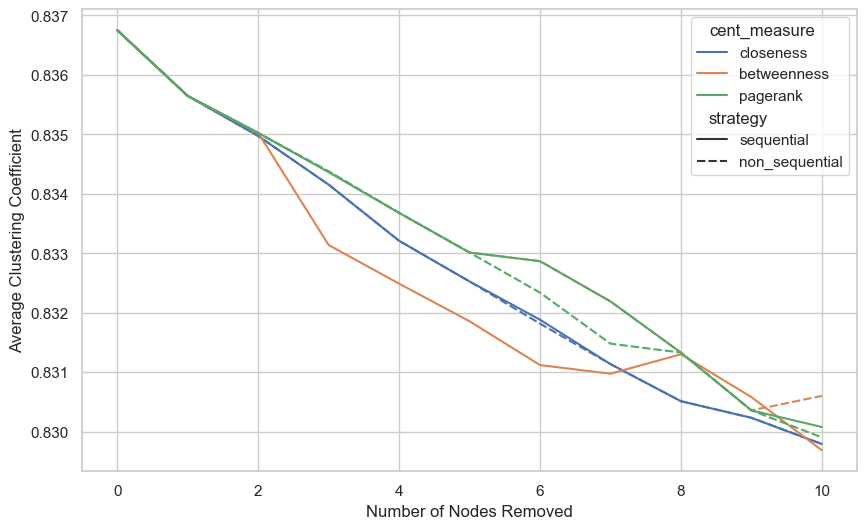

In [1092]:
impact_flat = pd.concat([df_clos_seq, 
                                  df_clos_nonseq, 
                                  df_bet_seq, 
                                  df_bet_nonseq, 
                                  df_pr_seq, 
                                  df_pr_nonseq]).reset_index()

plt.figure(figsize = (10,6))
sns.lineplot(data = impact_flat, x = 'index',y = 'acc', hue = 'cent_measure', style = 'strategy')
plt.xlabel('Number of Nodes Removed')
plt.ylabel('Average Clustering Coefficient')
plt.savefig('./figures/acc.png')
plt.show()

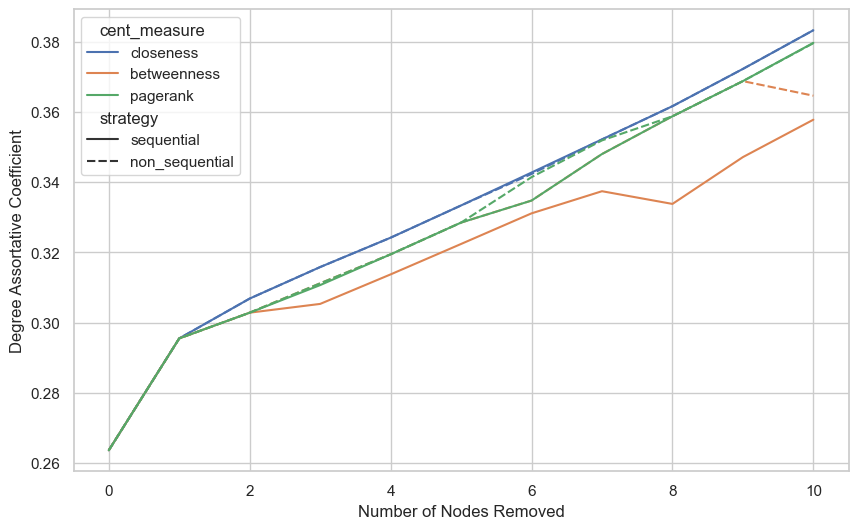

In [1091]:
plt.figure(figsize = (10,6))
sns.lineplot(data = impact_flat, x = 'index',y = 'dac', hue = 'cent_measure', style = 'strategy')
plt.xlabel("Number of Nodes Removed")
plt.ylabel("Degree Assortative Coefficient")
plt.savefig('./figures/dac.png')
plt.show()

## Flows: Weighted Network

### Centrality Measures

In [1050]:
list(g.edges(data = True))[0]

('Abbey Road', 'Bank and Monument', {'flows': 0.0})

In [1072]:
#offset values
flows_off = {(e1, e2): 0.00000001 if flows ==0.0 else flows for e1, e2, flows in g.edges(data='flows')}
flows_off
# # Inverse weights:
inv_weights={(e1, e2):round(1./flows_off,7) for (e1, e2), flows_off in flows_off.items()}
inv_weights
# # Let us add the inversed weight as an attribute to the edges in the graph
nx.set_edge_attributes(g, inv_weights, 'inv_weights')

# # Print edge list with attributes
list(g.edges(data = True))[0:15]

[('Abbey Road',
  'Bank and Monument',
  {'flows': 0.0, 'inv_weights': 100000000.0}),
 ('Abbey Road', 'Beckton', {'flows': 1.0, 'inv_weights': 1.0}),
 ('Abbey Road', 'Blackwall', {'flows': 3.0, 'inv_weights': 0.3333333}),
 ('Abbey Road', 'Canary Wharf', {'flows': 1.0, 'inv_weights': 1.0}),
 ('Abbey Road', 'Canning Town', {'flows': 37.0, 'inv_weights': 0.027027}),
 ('Abbey Road', 'Crossharbour', {'flows': 1.0, 'inv_weights': 1.0}),
 ('Abbey Road', 'Custom House', {'flows': 0.0, 'inv_weights': 100000000.0}),
 ('Abbey Road', 'Cutty Sark', {'flows': 2.0, 'inv_weights': 0.5}),
 ('Abbey Road', 'Cyprus', {'flows': 7.0, 'inv_weights': 0.1428571}),
 ('Abbey Road', 'Devons Road', {'flows': 1.0, 'inv_weights': 1.0}),
 ('Abbey Road', 'East India', {'flows': 2.0, 'inv_weights': 0.5}),
 ('Abbey Road', 'Island Gardens', {'flows': 2.0, 'inv_weights': 0.5}),
 ('Abbey Road', 'King George V', {'flows': 5.0, 'inv_weights': 0.2}),
 ('Abbey Road', 'Langdon Park', {'flows': 8.0, 'inv_weights': 0.125}),
 ('Ab

#### Closeness Centrality

In [1076]:
#topological closeness
closeness_w=nx.closeness_centrality(g, distance = 'inv_weights')

# Let us add the closeness centrality as attribute to the nodes in the graph
nx.set_node_attributes(g,closeness_w,'closeness_w')

# To dataframe using the nodes as the index
df_clos_w = pd.DataFrame.from_dict(closeness_t,columns=['closeness_w'],orient='index')
df_clos_w_sorted = df_clos_w.sort_values(by = 'closeness_w', ascending=False).reset_index().rename(columns = {'index':'station_name'})
df_clos_w_sorted[0:10]

,station_name,closeness_w
0,Stratford,0.927739
1,Highbury & Islington,0.820619
2,Whitechapel,0.812245
3,Canada Water,0.810591
4,Canary Wharf,0.808943
5,Canning Town,0.807302
6,Bank and Monument,0.807302
7,Liverpool Street,0.805668
8,West Brompton,0.799197
9,Richmond,0.796000


In [ ]:
# Sequential Removal
g1 = g.copy()
df_clos_seq_w = node_removal(g1,'closeness', df_clos_t_sorted, True, True)
df_clos_seq_w

Number of Existing Nodes:399


NodeNotFound: Source flows is not in G

In [ ]:
# Non-sequential Removal
g2 = g.copy()
df_clos_nonseq_w = node_removal(g2,'closeness', df_clos_t_sorted, False, True)
df_clos_nonseq_w

#### Betweenness Centrality

In [1080]:
### Topological betweenness centrality:

#Compute the betweenness centrality for the network, without using weights:
betweenness_w=nx.betweenness_centrality(g, normalized=True, weight = 'flows')

# We can add these values to the nodes attributes:
nx.set_node_attributes(g,betweenness_w,'betweenness_w')

# To dataframe using the nodes as the index
df_bet_w = pd.DataFrame.from_dict(betweenness_w,columns=['betweenness_w'],orient='index')
df_bet_w_sorted = df_bet_w.sort_values(by = 'betweenness_w', ascending=False).reset_index().rename(columns = {'index':'station_name'})
df_bet_w_sorted[0:10]

,station_name,betweenness_w
0,West Ham,2.100878e+62
1,Bank and Monument,1.691375e+61
2,Stratford,6.486951e+60
3,North Wembley,5.312595e+58
4,Kensington,1.437762e+58
5,Harlesden,1.355975e+58
6,Custom House,3.392502e+57
7,Prince Regent,1.622960e+57
8,Gallions Reach,1.622960e+57
9,Kensal Green,3.726589e+56


#### Pagerank

In [1078]:
pagerank_w = nx.pagerank(g, weight = 'flows')

# We can add these values to the nodes attributes:
nx.set_node_attributes(g,pagerank_w,'pagerank_w',)

# To dataframe using the nodes as the index
df_pr_w = pd.DataFrame.from_dict(pagerank_t,columns=['pagerank_w'],orient='index')
df_pr_w_sorted = df_pr_w.sort_values(by = 'pagerank_w', ascending=False).reset_index().rename(columns = {'index':'station_name'})
df_pr_w_sorted[0:10]

,station_name,pagerank_w
0,Bank and Monument,0.047941
1,Liverpool Street,0.032838
2,Canary Wharf,0.031984
3,Stratford,0.024877
4,Oxford Circus,0.019319
5,King's Cross St. Pancras,0.018123
6,Victoria,0.017651
7,London Bridge,0.017235
8,Farringdon,0.016087
9,Waterloo,0.014429
